# Pairing Tutorial
We will demonstrate how to calculate ion pairs in a solution of ionic liquids.
Pairing of molecules is determined by a distance criteria, and the information is stored in a direct correlation matrix.  The direct correlation matrix is constructed from a diagonal matrix of size NxN where N is the number of molecules in the system.  Each row (or column) can be thought of the connections that a particular molecule has with the other molecules in the system.  If molecule `i` is more than distance criteria away from molecule `j`, they are not connected and a 0 is placed in the `i,j` position of the matrix.  If the distance between the two molecules are less than the distance criteria, the molecules are considered to be paired and a 1 is placed in the position instead.

For this example, we will load in a trajectory containing the ionic liquid, ($[BMIM^+][Tf_2N^-]$), and dichloromethane.  We will calculate the pairs and clusters of ions in solution.

### Import necessary packages

In [2]:
import mdtraj as md
import pairing
import numpy as np
import matplotlib.pyplot as plt

### First, let's use MDTraj to load a GROMACS trajectory

In [4]:
trj = md.load('sample_files/slice.xtc', top='sample_files/sample.gro')

Now we will slice the trajectory to only include the ions $BMIM^+$ and $Tf_2N^-$

In [6]:
sliced = trj.topology.select('resname bmim tf2n')
trj_slice = trj.atom_slice(sliced)

Next let's call `pairing.calc_direct` to calculate a direct correlation matrix for each frame of the trajectory.  We choose 0.53 nm as our `cutoff` distance as this correlates to the first radial distribution (RDF) peak between $BMIM^+$ and $Tf_2N^-$ 

In [7]:
pairs = pairing.calc_direct(trj_slice, cutoff=0.53)

Now that we've calculated direct correlation matrices for each frame, let's inspect the matrix for the first frame and see what's going on.

In [8]:
pairs[0]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

From first glance, we can see from the 1's in non-diagonal indices that some ions are paired with each other.  Let's take a look at the pairings for the ion in the first row.

In [9]:
first = pairs[0][0]

In [10]:
print(first)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
np.argwhere(first>0)

array([[ 0],
       [61]])

By running `np.argwhere`, we see that there is a value of 1 in two indices of the first row of the matrix: 0 and 37.  We can ignore the 1 in the index 0 as this corresponds to the ion we are computing pairs for.  However, we see that ion 1 is paired to ion 81.

Now we can loop through all the rows in this matrix and check how many pairs each ions has.

In [8]:
for i,j in enumerate(pairs[0]):
    num_pairs = len(np.argwhere(j>0)) - 1
    print('ion {} has {} total pairs'.format(i+1, num_pairs))

ion 1 has 1 total pairs
ion 2 has 0 total pairs
ion 3 has 1 total pairs
ion 4 has 3 total pairs
ion 5 has 2 total pairs
ion 6 has 1 total pairs
ion 7 has 2 total pairs
ion 8 has 2 total pairs
ion 9 has 2 total pairs
ion 10 has 1 total pairs
ion 11 has 0 total pairs
ion 12 has 1 total pairs
ion 13 has 0 total pairs
ion 14 has 1 total pairs
ion 15 has 0 total pairs
ion 16 has 1 total pairs
ion 17 has 2 total pairs
ion 18 has 0 total pairs
ion 19 has 1 total pairs
ion 20 has 0 total pairs
ion 21 has 1 total pairs
ion 22 has 1 total pairs
ion 23 has 0 total pairs
ion 24 has 0 total pairs
ion 25 has 2 total pairs
ion 26 has 1 total pairs
ion 27 has 2 total pairs
ion 28 has 2 total pairs
ion 29 has 1 total pairs
ion 30 has 0 total pairs
ion 31 has 0 total pairs
ion 32 has 1 total pairs
ion 33 has 0 total pairs
ion 34 has 1 total pairs
ion 35 has 1 total pairs
ion 36 has 0 total pairs
ion 37 has 0 total pairs
ion 38 has 0 total pairs
ion 39 has 0 total pairs
ion 40 has 1 total pairs
ion 41 ha

We can also check the total number of pairs in this trajectory frame.  We will do this by counting the pairs in each row and then dividing by 2 to prevent double-counting the pairs.  

In [13]:
total_pairs = 0
for i,j in enumerate(pairs[0]):
    num_pairs = len(np.argwhere(j>0)) - 1
    total_pairs += num_pairs
total_pairs /= 2
print('The total number of ion pairs in this frame is {}'.format(int(total_pairs)))

The total number of ion pairs in this frame is 44


We can also compute if there are any clusters of ions in solution.  To do this we first calculate the direct matrices for all frames.  This is slightly different from what we did previously, as we calculated the ion pairs in the first frame, and then checked to see if those pairs remained in the remaining frames.

In [9]:
all_directs = pairing.calc_direct(trj_slice, cutoff=0.53)

Then, convert the direct correlation matrix to an indirect correlation matrix.  An indirect connection is when ion i is paired with ion j, and ion j is paired with ion k.  In this instance, ion i is indirectly correlated to ion k.

In [15]:
all_indirects = pairing.calc_indirect(all_directs)

From the indirect correlation matrix, we can determine if any clusters of ions exist in our system by reducing the matrices.  The resulting matrix shows which cluster each molecule belongs to.  We can then sum each column in the matrix together to determine the size of each cluster, which is shown in the for-loop below.

In [88]:
clusters = pairing.calc_reduc(all_indirects)

In [89]:
cluster_count = list()
cluster_sizes = list()
for matrix in clusters:
    for i in range(len(matrix[0])):
        cluster_count.append(np.sum(matrix[:,i]))
    cluster_sizes.append(cluster_count)

In [90]:
flat_list = [item for sublist in cluster_sizes for item in sublist]
bins = np.array(range(np.max(flat_list)))
x = np.histogram(flat_list, bins=bins)

We can  plot a histogram of the cluster sizes.  From these results, we see that the majority of ions are alone and are not clustered.  However there are clusters that exist in this system of sizes 2 to 6.

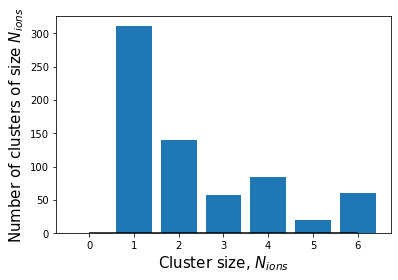

In [91]:
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlabel(r'Cluster size, $N_{ions}$', fontsize=15)
ax.set_ylabel(r'Number of clusters of size $N_{ions}$', fontsize=15)
ax.hlines(0, min(x[1][:-1]), max(x[1][:-1]))
ax.bar(x[1][:-1], x[0]/len(cluster_sizes)*x[1][:-1])

plt.show()